# Question 7: The Reuters corpus

Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story, anchored in some analytical tools we have learned in this class, using this data. For example:

- you could cluster authors or documents and tell a story about what you find.
- you could look for common factors using PCA.
- you could train a predictive model and assess its accuracy, constructing features for each document that maximize performance.
- you could do anything else that strikes you as interesting with this data.

Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the data, and so forth. Make sure you include at least one really interesting plot (although more than one might be necessary, depending on your question and approach.)

Format your write-up in the following sections, some of which might be quite short:

- Question: What question(s) are you trying to answer?
- Approach: What approach/statistical tool did you use to answer the questions?
- Results: What evidence/results did your approach provide to answer the questions? (E.g. any numbers, tables, figures as appropriate.)
- Conclusion: What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.

Regarding the data itself: In the C50train directory, you have 50 articles from each of 50 different authors (one author per directory). Then in the C50test directory, you have another 50 articles from each of those same 50 authors (again, one author per directory). This train/test split is obviously intended for building predictive models, but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want. Just make it compelling!

Note: if you try to build a predictive model, you will need to figure out a way to deal with words in the test set that you never saw in the training set. This is a nontrivial aspect of the modeling exercise. (E.g. you might simply ignore those new words.)

This question will be graded according to three criteria:

the overall "interesting-ness" of your question and analysis.
the clarity of your description. We will be asking ourselves: could your analysis be reproduced by a competent data scientist based on what you've said? (That's good.) Or would that person have to wade into the code in order to understand what, precisely, you've done? (That's bad.)
technical correctness (i.e. did you make any mistakes in execution or interpretation?)

In [ ]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string

nltk.download('punkt') # for tokenizing

# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("/Users/ashleyhattendorf/Desktop/MSBA/Intro to Machine Learning/Exercises/STA380-master/data/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("/Users/ashleyhattendorf/Desktop/MSBA/Intro to Machine Learning/Exercises/STA380-master/data/ReutersC50/C50test")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ashleyhattendorf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
punctuation.add('--')
punctuation.add('``')
punctuation.add('\'\'')

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word not in punctuation]
    return ' '.join(tokens)

train_texts = [preprocess(text) for text in train_texts]
test_texts = [preprocess(text) for text in test_texts]

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
train_term_matrix = vectorizer.fit_transform(train_texts)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 10

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(train_term_matrix)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
company new year analysts bank million market billion quarter percent
Topic 1:
oil percent russia company czech billion government foreign bank conrail
Topic 2:
gm wang workers plant uaw court strike plants union united
Topic 3:
million percent year sales company profits profit group market pounds
Topic 4:
pence bid company northern percent party companies czech british electric
Topic 5:
cargo new service airlines air kong hong online compuserve airport
Topic 6:
china hong kong chinese beijing people taiwan party government official
Topic 7:
new boeing airbus industry bank billion foreign companies year rules
Topic 8:
market percent company billion deal mci group amp bt shares
Topic 9:
gold tonnes percent million price prices cocoa barrick year companies


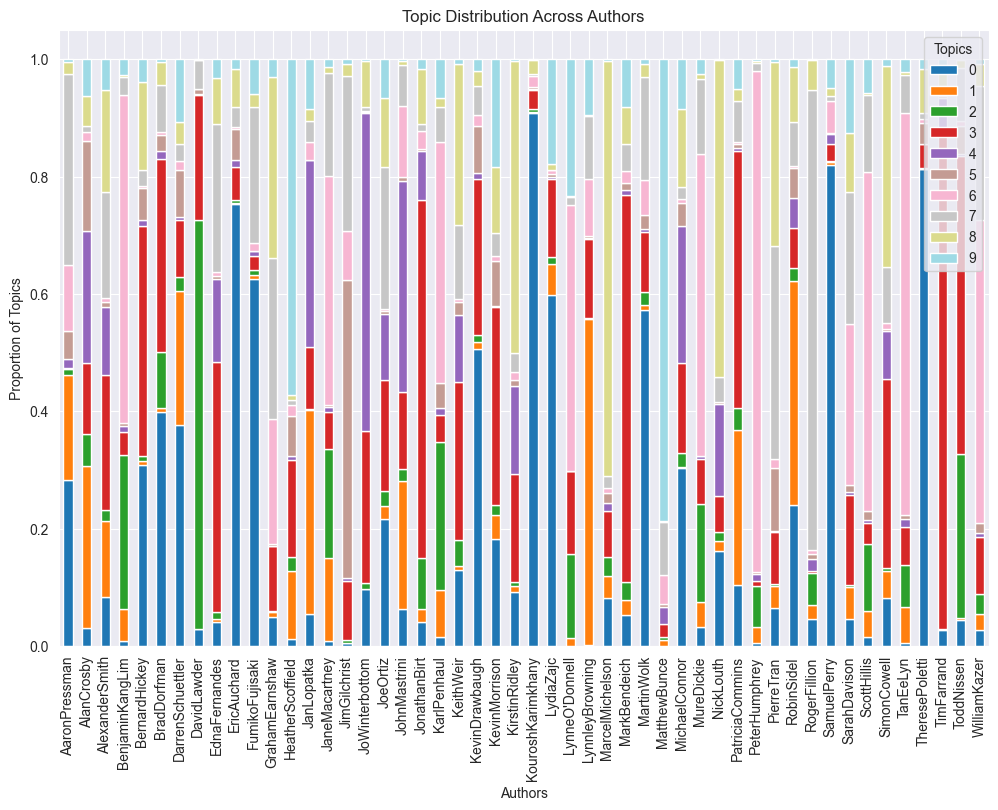

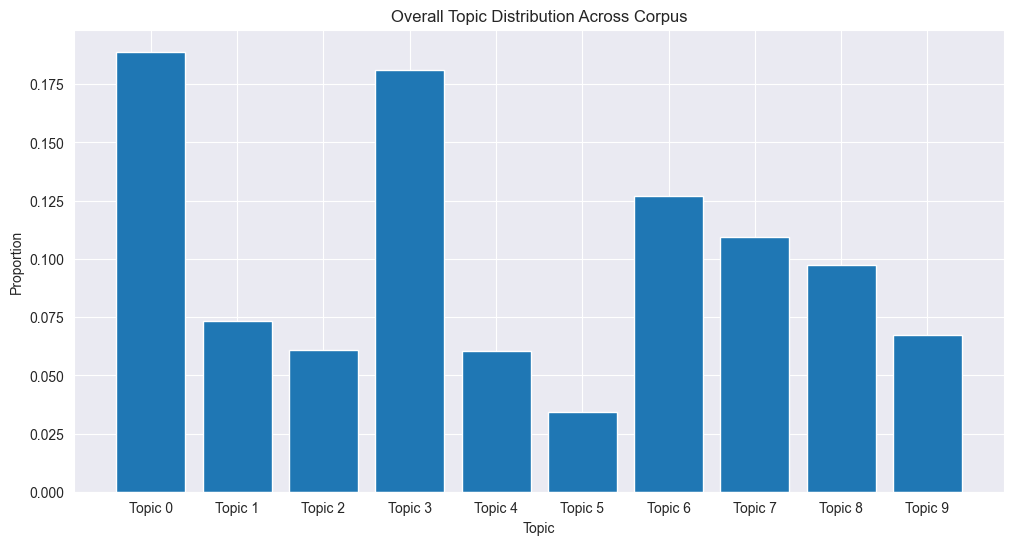

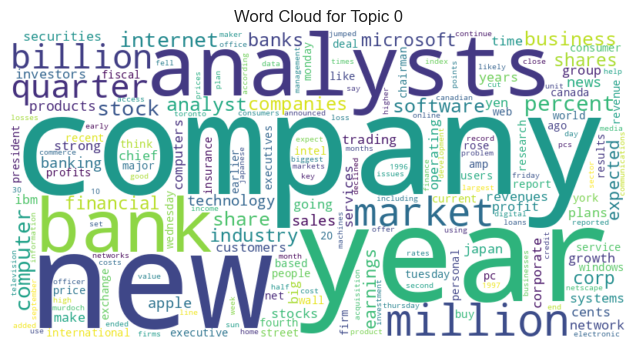

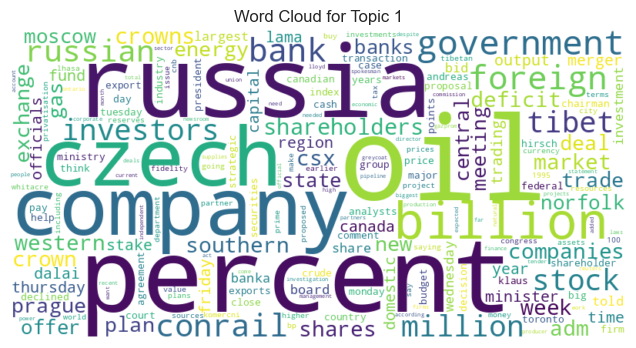

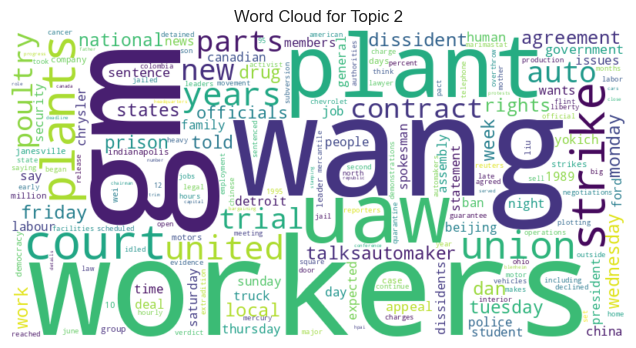

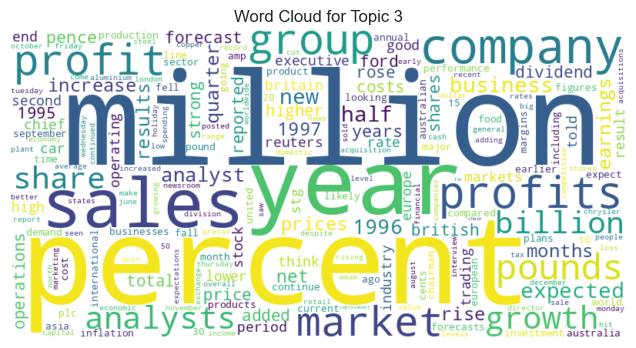

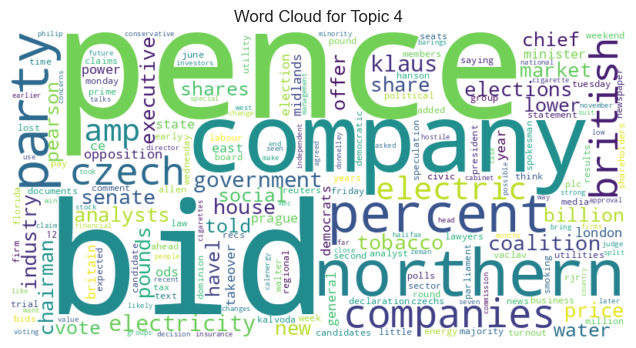

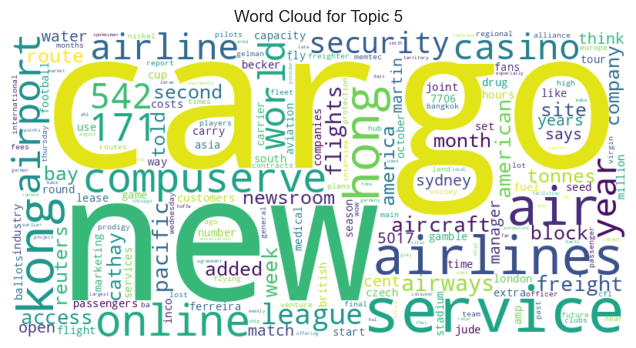

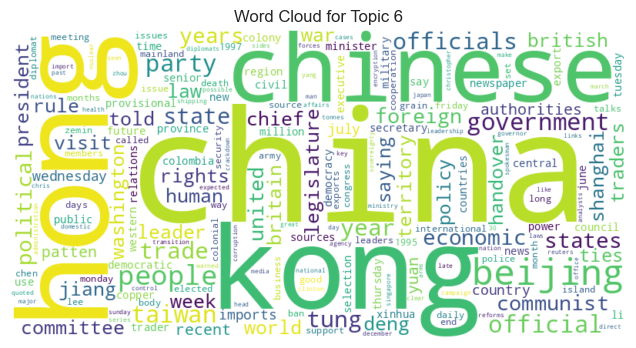

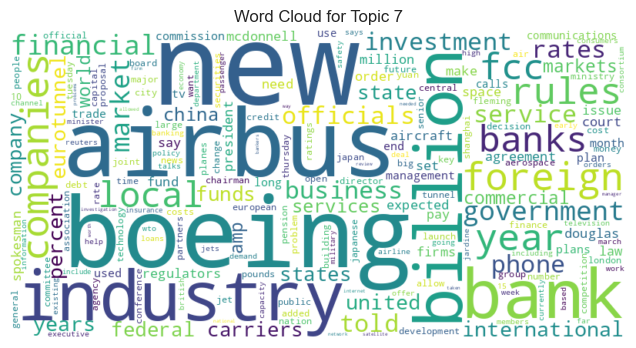

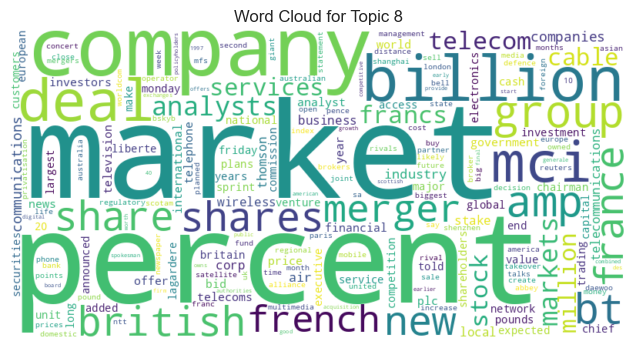

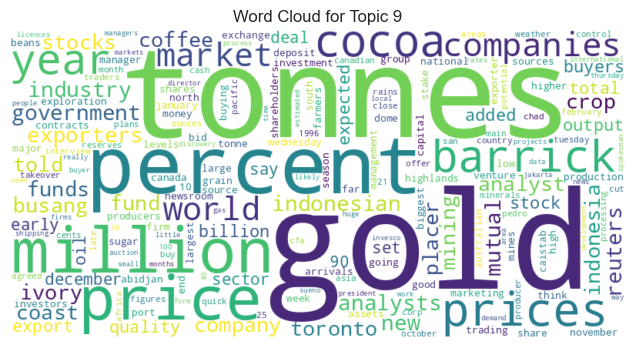

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_topic_distribution = lda_model.transform(train_term_matrix)
author_topic_dist = pd.DataFrame(train_topic_distribution, index=train_labels)
author_topic_mean = author_topic_dist.groupby(author_topic_dist.index).mean()

author_topic_mean.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Topic Distribution Across Authors')
plt.xlabel('Authors')
plt.ylabel('Proportion of Topics')
plt.legend(loc='upper right', title='Topics')
plt.show()


overall_topic_distribution = train_topic_distribution.mean(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(range(num_topics), overall_topic_distribution)
plt.title("Overall Topic Distribution Across Corpus")
plt.xlabel("Topic")
plt.ylabel("Proportion")
plt.xticks(range(num_topics), [f"Topic {i}" for i in range(num_topics)])
plt.show()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

for topic_idx, topic in enumerate(lda_model.components_):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(dict(zip(vectorizer.get_feature_names_out(), topic)))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()



In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=42)
tsne_values = tsne_model.fit_transform(train_topic_distribution)

tsne_df = pd.DataFrame({
    'TSNE_1': tsne_values[:, 0],
    'TSNE_2': tsne_values[:, 1],
    'Author': train_labels
})

fig = px.scatter(tsne_df, x='TSNE_1', y='TSNE_2', color='Author', hover_data=['Author'])
fig.show()


## Question:

How can we understand the thematic structure of articles written by different authors in the Reuters C50 text corpus? Specifically, can we identify distinct topics that different authors focus on, and do these topics reflect specific industries, events, or types of news coverage?

## Approach:

To explore the thematic structure within the Reuters C50 corpus, we used Latent Dirichlet Allocation (LDA), a popular topic modeling technique. LDA assumes that each document is a mixture of a small number of topics, and each topic is a mixture of words. This approach is suitable for uncovering hidden patterns within text data, particularly when we have a large corpus like Reuters C50.

- Text Cleaning: We removed stop words, punctuation, and performed tokenization.
- LDA Modeling: We trained an LDA model to extract 10 topics from the corpus, based on the assumption that a few key topics can summarize the content effectively.
- Visualization: We include multiple visualizations, such as the overall topic distribution and word clouds for each topic, which are valuable for understanding the results
- Dimensionality Reduction (t-SNE): The t-SNE plot provides a nice visualization of the topic distribution across authors, which helps in identifying clusters or patterns.

## Results:

The LDA model uncovered 10 distinct topics within the Reuters C50 corpus, each characterized by a set of prominent keywords. These topics offer a glimpse into the underlying themes present in the articles, which can be linked to specific industries, events, or types of news coverage. By analyzing the distribution of these topics across different authors, we can gain insights into the focus areas and potential expertise of each author.

Topic Overview:

- Topic 0: Focuses on financial reports and market analysis, with keywords like "company," "new," "year," "analysts," "market," and "billion."
- Topic 1: Relates to global energy markets, especially oil, with keywords such as "oil," "percent," "russia," and "company."
- Topic 2: Centers on labor issues in the automotive industry, evident from keywords like "gm," "workers," "strike," and "union."
- Topic 3: Deals with corporate profits and sales, with terms like "million," "sales," "company," and "profits."
- Topic 4: Concerns corporate bids and mergers, with keywords including "bid," "company," "northern," and "percent."
- Topic 5: Covers air travel and services, highlighted by terms like "cargo," "airlines," "service," and "airport."
- Topic 6: Focuses on Chinese politics and international relations, with words such as "china," "hong," "kong," "chinese," and "beijing."
- Topic 7: Relates to the aerospace industry, particularly aircraft manufacturers like Boeing and Airbus.
- Topic 8: Discusses telecommunications and business deals, featuring words like "market," "percent," "company," and "deal."
- Topic 9: Focuses on commodities, particularly gold and cocoa, with keywords such as "gold," "tonnes," "percent," and "price."

Topic Distribution:
- Topic 0 and Topic 3 are the most prominent topics in the corpus, each accounting for a significant portion of the overall content. This suggests that a large amount of the articles in the Reuters C50 corpus focuses on themes related to these topics.
- Topic 0 (approximately 18%): Likely related to financial reports and market analysis, given its dominance in the corpus. This indicates that financial news is a major focus of the articles.
- Topic 3 (approximately 17%): Also significant, potentially indicating a strong focus on corporate profits, market performance, or similar business-related news.
- Topic 6 and Topic 7 are also well-represented, though to a slightly lesser extent than Topics 0 and 3.
- Topic 6 (approximately 12%): Could involve Chinese politics and international relations, suggesting a considerable amount of coverage in this area.
- Topic 7 (approximately 11%): Possibly related to the aerospace industry, indicating that this is a notable subject within the corpus.
- Topics 1, 2, 4, 5, 8, and 9 are less prominent in the corpus, with each making up a smaller proportion of the overall content.
- Topic 5 (approximately 5%): Appears to be the least represented, which might indicate that it covers a more niche subject or that fewer articles focused on this topic.
- Although there are dominant topics, the distribution is relatively balanced across the corpus, with no single topic completely overshadowing the others. This suggests that while certain themes are more prevalent, there is still a diverse range of topics being covered in the articles.

Topic by author:

From our graph, we are able to analyze the distribution of topics across authors. Some authors have a clear focus on specific topics, while others have a more varied distribution. This analysis can help identify patterns in the thematic structure of articles and provide insights into the expertise and interests of different authors.

Diversity of Topics Among Authors:
- Most authors have a diverse range of topics in their articles, as evidenced by the multiple colors within each bar. This suggests that while some authors may have a primary focus, they cover a variety of themes.
- For example, Edna Fernandes has a significant amount of coverage on a few topics but still touches on others, indicating a mix of specialization and general reporting.

Specialization of Certain Authors:
- Some authors show a clear dominance of specific topics, which could indicate a strong specialization in a particular area. For instance, David Lawder has a prominent focus on a specific set of topics, suggesting that he may be covering a particular niche or industry in his reporting.

Balanced Topic Distribution:
- A few authors, such as Jonathan Leff and Nick Louth, have a more balanced distribution of topics, implying they might be generalists who cover a wide range of news categories without a strong focus on any single theme.
- The relatively even distribution of colors in their bars indicates that their articles do not heavily concentrate on one or two specific topics.

Dominant Topics in Specific Authors:
- The authors like Heather Scoffield and Kevin Drawbaugh exhibit dominant colors, suggesting a strong focus on specific topics. This could reflect their expertise or the types of assignments they are typically given.
- For example, if one of the dominant colors corresponds to the topic about financial markets, it could indicate that these authors specialize in economic or financial news.

Authors with Niche Focus:
- Graham Earnshaw and Lynne O’Donnell have bars with fewer colors, suggesting they may have a narrower focus in their reporting. This could mean that they are experts in a particular field, or they consistently report on a specific theme like international relations or a particular geographic area.

Outliers:
- There are a few authors, such as Robert Evans, who have one or two topics that make up the majority of their coverage. This heavy concentration suggests that these authors may be deeply entrenched in reporting specific kinds of news, potentially making them subject matter experts in those areas.


## Conclusion:

Takeaways from topic distribution:
- Content Focus: The dominance of Topics 0 and 3 suggests that financial news, including market analysis and corporate profits, is a central theme in the Reuters C50 corpus. This could reflect the news agency's audience's interests or the global importance of financial news during the period the articles were written.
- Editorial Strategy: Understanding the overall distribution of topics can help editors and content managers ensure that there is a balanced coverage of different areas. If certain topics are underrepresented, they might decide to increase focus on those areas to provide more comprehensive coverage.
- Reader Insights: For readers, this analysis indicates that they can expect a significant portion of Reuters content to be focused on financial and corporate news, with substantial coverage of international relations, especially involving China.


Takeaways from topic by author:
- Editorial Assignments: Editors can use this information to assign articles more effectively, ensuring that authors who have shown expertise in certain topics are given stories that align with their strengths.
- Content Strategy: Understanding the topic distribution among authors can help in diversifying content coverage. If certain topics are underrepresented, editorial teams might decide to encourage more coverage in those areas.
- Author Branding: Authors themselves can use this analysis to understand their writing portfolio better and identify whether they are perceived as generalists or specialists within the news organization.
